In [1]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

     |████████████████████████████████| 411.5MB 34kB/s 
     |████████████████████████████████| 412.3MB 44kB/s 
     |████████████████████████████████| 245kB 41.9MB/s 
     |████████████████████████████████| 174kB 38.3MB/s 
     |████████████████████████████████| 512kB 33.7MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 3.8MB 15.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=5f730b5d1bae35b2104d89addcf7a4987daed6197b1095ceeb182e241e0cef15
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalli

**Importing Dataset**

In [3]:
import pandas as pd

df = pd.read_csv('https://github.com/ene610/DRL_finance/blob/main/data/Binance_BTCUSDT_minute.csv?raw=true', skiprows=1)
df = df.rename(columns={'Volume USDT': 'volume'})
df = df.iloc[::-1]
df = df.drop(columns=['symbol', 'Volume BTC'])
df['date'] = pd.to_datetime(df['unix'],unit='ms')
df = df.set_index("date")
df = df.drop(columns=['unix'])
print(df.shape)
df.head(5)

(330483, 6)


,open,high,low,close,volume,tradecount
date,,,,,,
2020-09-11 20:40:00,10317.00,10317.01,10314.36,10316.00,340398.477553,342
2020-09-11 20:41:00,10316.00,10321.09,10316.00,10319.50,168497.705251,256
2020-09-11 20:42:00,10319.50,10320.31,10318.49,10319.34,125108.931436,193
2020-09-11 20:43:00,10319.34,10320.14,10318.89,10319.00,139806.963489,187
2020-09-11 20:44:00,10318.99,10319.72,10316.58,10319.47,149266.708094,284


**Implementing Env**

In [4]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
from enum import Enum
from matplotlib import pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [10]:
from enum import Enum

class Actions(Enum):
    # Mappo sono le azioni legittime nella forma:
    # StatoAzione
    DoNothing = 0
    OpenPosition = 1
    HoldPosition = 2
    ClosePosition = 3

    # Potrei anche mappare solo le quattro azioni e poi dare il reward negativo sull'azione in base alla posizione corrente (che comunque devo tenermi salvata)


class Positions(Enum):
    # La posizione è lo stato attuale in cui si trova l'algoritmo.
    # In Free è permesso solo di fare DoNothing e OpenPosition
    # in Long è permesso di fare solo HoldPosition e ClosePosition
    Free = 0
    Long = 1

    def opposite(self):
        return Positions.Free if self == Positions.Long else Positions.Long

In [11]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

class CryptoTradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, frame_bound, window_size):
        assert df.ndim == 2
        assert len(frame_bound) == 2

        self.seed()
        self.df = df
        self.frame_bound = frame_bound
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._open_position_tick = None
        self._last_trade_tick = None
        self._position = Positions.Free
        self._position_history = None
        self._total_reward = 0.
        self._total_profit = 1.
        self._first_rendering = None
        self.history = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._open_position_tick = 0
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Free
        self._position_history = (self.window_size * [0]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        valid, step_reward = self._calculate_reward(action)
        self._total_reward += step_reward
        if valid:
          self._update_profit(action)
        else:
          # Se l'azione non è valida lo costringo ad imparare che non è valida, gli do un reward negativo e fermo l'episodio
          self._total_reward = -1000
          self._done = True

        if action == Actions.ClosePosition.value and self._position == Positions.Long:
            self._position = self._position.opposite()

        if action == Actions.OpenPosition.value and self._position == Positions.Free:
            self._position = self._position.opposite()
            self._open_position_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info

    def _action_is_invalid(self, action):
        if self._position == Positions.Free.value and (action == Actions.ClosePosition.value or action == Actions.HoldPosition):
            return True
        if self._position == Positions.Long.value and (action == Actions.OpenPosition or action == Actions.DoNothing):
            return True
        return False

    def _calculate_reward(self, action):
        step_reward = 0

        # Controllo di avere una azione valida
        # Se è una azione invalida, il reward tornato sarà settato negativo dal metodo che richiama questo
        if self._action_is_invalid(action):
            return False, -1

        # Da qui in poi ho solo azioni valide:
        trade = False
        if ((action == Actions.OpenPosition.value and self._position == Positions.Free) or
            (action == Actions.ClosePosition.value and self._position == Positions.Long)):
            trade = True

        if action == Actions.HoldPosition and self._position == Positions.Long:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._open_position_tick]
            price_diff = current_price - last_trade_price
            step_reward += price_diff

        if trade:
            if action == Actions.OpenPosition.value:
                # Lo incentivo ad acquistare
                step_reward = 10
            elif action == Actions.ClosePosition.value:
                # Qui ci dovrebbe entrare per forza se è entrato nel primo if ma non nel secondo
                # Qui sta chiudendo la posizione Long!
                current_price = self.prices[self._current_tick]
                last_trade_price = self.prices[self._open_position_tick]
                price_diff = current_price - last_trade_price
                step_reward += price_diff

        return True, step_reward

    def _update_profit(self, action):
        if action == Actions.ClosePosition.value and self._position == Positions.Long:
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            self._total_profit += current_price - open_position_price

        #if action == Actions.HoldPosition.value and self._position == Positions.Long:
        #    current_price = self.prices[self._current_tick]
        #    open_position_price = self.prices[self._open_position_tick]
        #    self._total_profit = current_price - open_position_price

    def _get_observation(self):
        return self.signal_features[(self._current_tick - self.window_size):self._current_tick]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def render(self, mode='human'):
        def _plot_position(position, tick):
            color = None
            if position == Positions.Free:
                color = 'grey'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)

    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Free:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        prices = self.df['close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features

    #############################################################################################################

    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

**Register and Init Env**

In [12]:
id_str = 'cryptostocks-v1'

del  gym.envs.registry.env_specs['cryptostocks-v1']

from gym.envs.registration import register
register(
    id=id_str,
    entry_point=CryptoTradingEnv,
)

**Declare and Train Agent**

In [22]:
env_maker = lambda: gym.make(id_str, df=df, frame_bound=(22,10000), window_size=22)
env = DummyVecEnv([env_maker])

In [23]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=150000)

---------------------------------
| explained_variance | 0.00284  |
| fps                | 19       |
| nupdates           | 1        |
| policy_entropy     | 1.38     |
| total_timesteps    | 5        |
| value_loss         | 39.5     |
---------------------------------
---------------------------------
| explained_variance | -3.1e-05 |
| fps                | 308      |
| nupdates           | 100      |
| policy_entropy     | 1.38     |
| total_timesteps    | 500      |
| value_loss         | 58.8     |
---------------------------------
---------------------------------
| explained_variance | -0.397   |
| fps                | 337      |
| nupdates           | 200      |
| policy_entropy     | 1.38     |
| total_timesteps    | 1000     |
| value_loss         | 2.19e-05 |
---------------------------------
----------------------------------
| explained_variance | -0.000215 |
| fps                | 348       |
| nupdates           | 300       |
| policy_entropy     | 1.38      |
| total_t

info {'total_reward': 1031.2699999999895, 'total_profit': 62.26999999998952, 'position': 1}


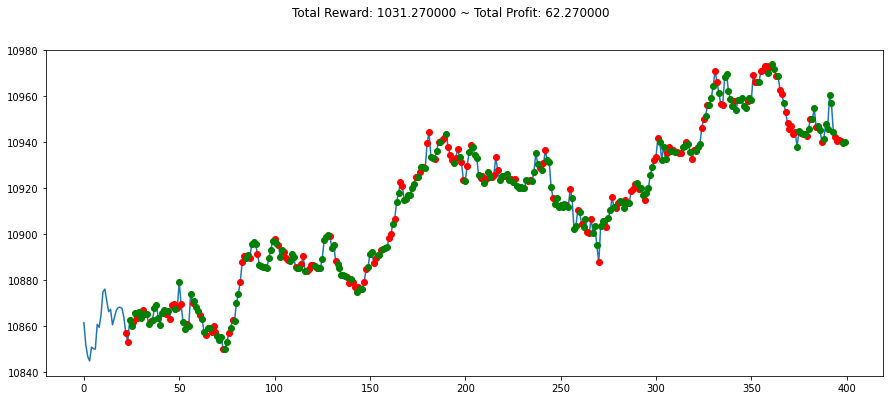

info {'total_reward': 1011.1700000000073, 'total_profit': 42.17000000000735, 'position': 1}


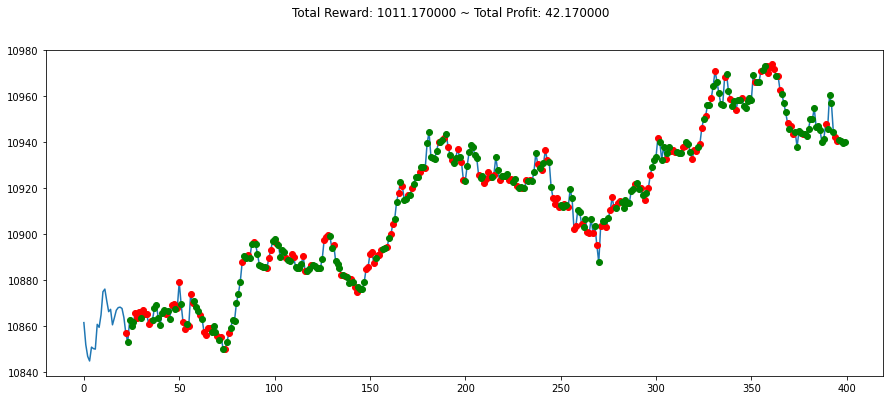

info {'total_reward': 958.9999999999945, 'total_profit': 99.99999999999454, 'position': 1}


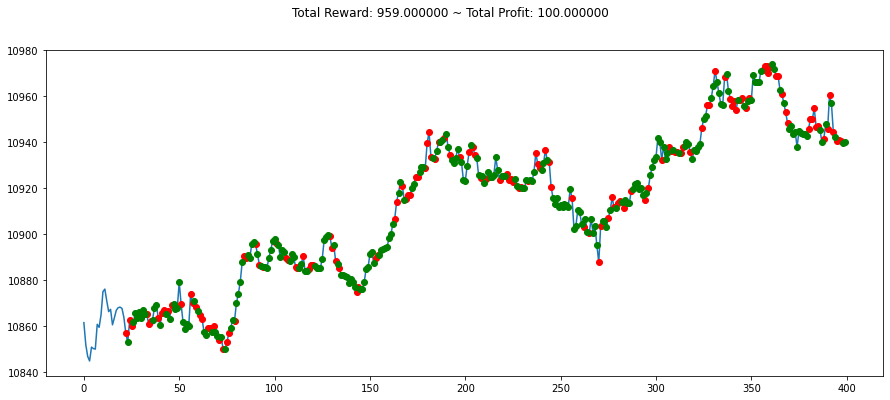

info {'total_reward': 993.8600000000006, 'total_profit': 14.860000000000582, 'position': 1}


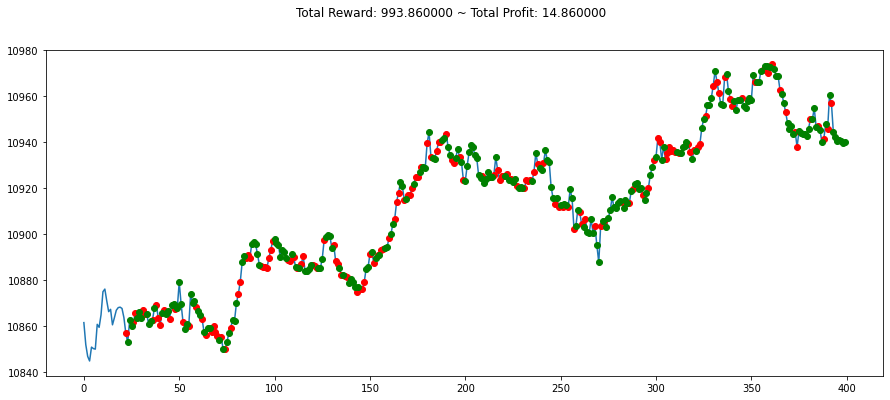

info {'total_reward': 809.5499999999956, 'total_profit': -59.450000000004366, 'position': 1}


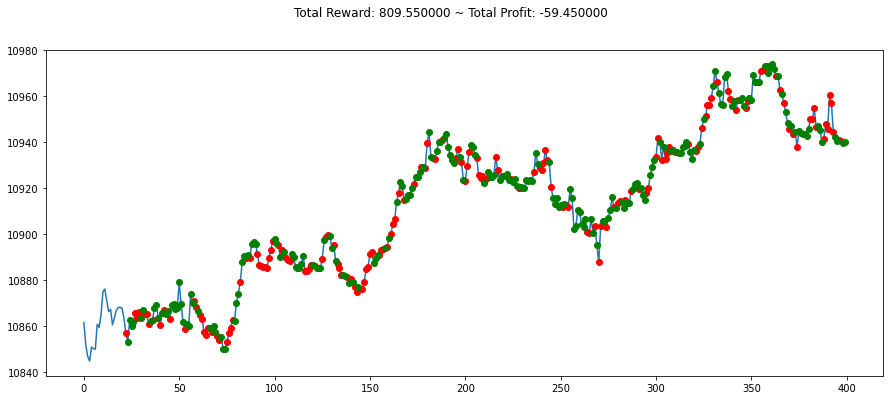

info {'total_reward': 988.0100000000057, 'total_profit': 29.010000000005675, 'position': 0}


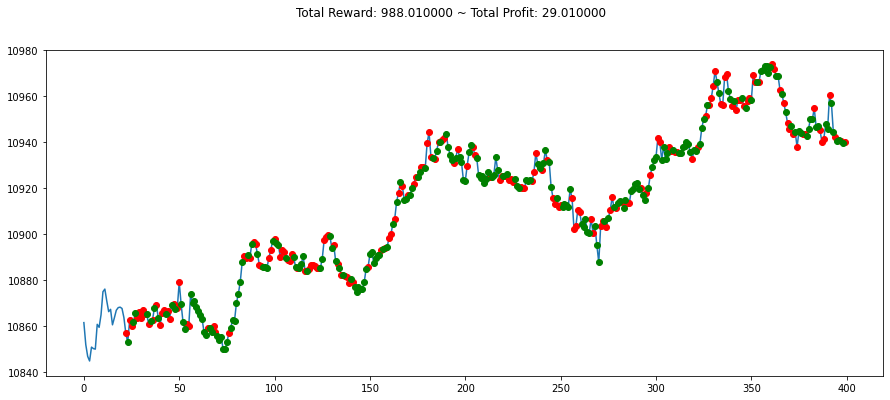

info {'total_reward': 979.8299999999872, 'total_profit': 60.829999999987194, 'position': 1}


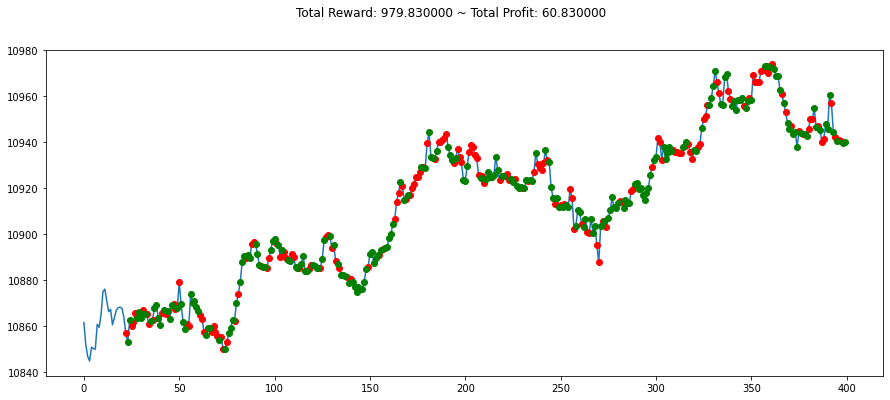

info {'total_reward': 904.0099999999911, 'total_profit': 65.00999999999112, 'position': 0}


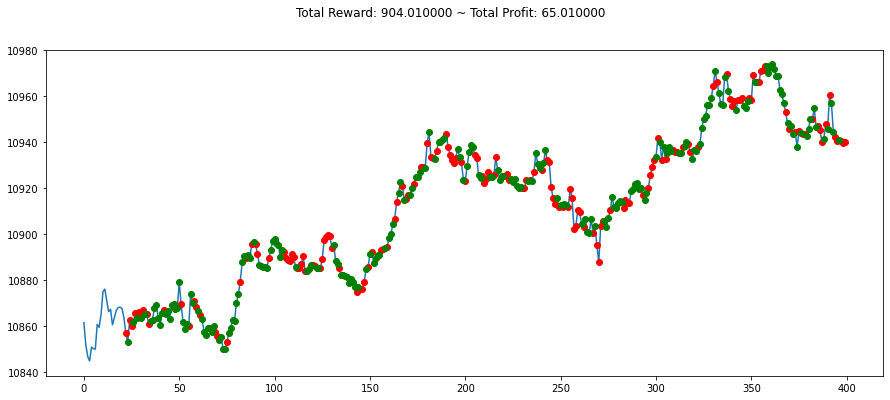

info {'total_reward': 1055.430000000002, 'total_profit': 66.43000000000211, 'position': 1}


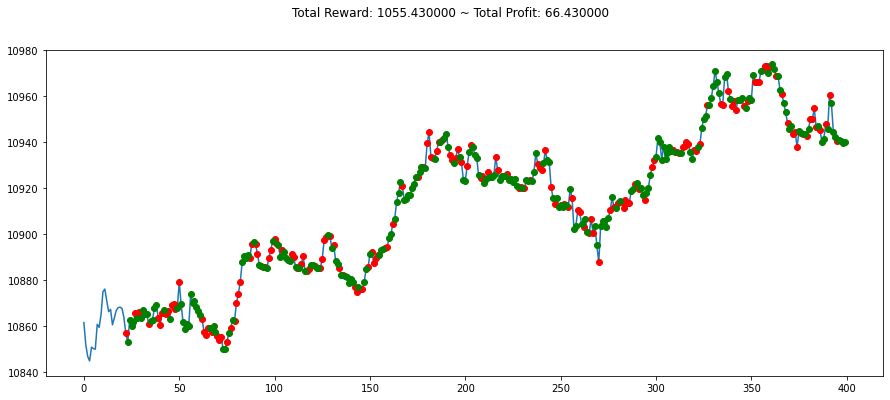

{'total_reward': 1031.2699999999895, 'total_profit': 62.26999999998952, 'position': 1}
{'total_reward': 1011.1700000000073, 'total_profit': 42.17000000000735, 'position': 1}
{'total_reward': 958.9999999999945, 'total_profit': 99.99999999999454, 'position': 1}
{'total_reward': 993.8600000000006, 'total_profit': 14.860000000000582, 'position': 1}
{'total_reward': 809.5499999999956, 'total_profit': -59.450000000004366, 'position': 1}
{'total_reward': 988.0100000000057, 'total_profit': 29.010000000005675, 'position': 0}
{'total_reward': 979.8299999999872, 'total_profit': 60.829999999987194, 'position': 1}
{'total_reward': 904.0099999999911, 'total_profit': 65.00999999999112, 'position': 0}
{'total_reward': 1055.430000000002, 'total_profit': 66.43000000000211, 'position': 1}


In [28]:
#330483
# frame_bound=(22, 401)
infos = []
for j in range(1, 10):
  env = gym.make(id_str, df=df, frame_bound=(10001,10379), window_size=22)
  obs = env.reset()
  # done = False in due casi:
  #                     - quando viene fatta una azione invalida (ma a quanto pare ha imparato a non farne)
  #                     - quando finisce tutti i timesteps passati in frame bound. Siccome in step immediatamente viene fatto il +1 bisogna che impostare
  #                         range(frame_bound.min, frame_bound.max -1)
  for i in range(10001, 10378): 
      obs = obs[np.newaxis, ...]
      action, _states = model.predict(obs)
      obs, rewards, done, info = env.step(action)
      if done:
          print("info", info)
          infos.append(info)
          plt.figure(figsize=(15,6))
          plt.cla()
          env.render_all()
          plt.show()
for i in infos:
  print(i)